# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
from itertools import combinations
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="/aiffel/aiffel/dlthon-minions/share/data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
4026,4026,기타 괴롭힘 대화,이상 발표를 마치겠습니다. \n질문 하나 해도 될까요? 이해 가지 않는 부분이 있어...
1504,1504,직장 내 괴롭힘 대화,박대리 이거 보고서에 맞춤법이 왜이렇게 엉망이지\n죄송합니다\n너 머리가있으면 생각...
804,804,협박 대화,야 니동생 엄청 예쁘더라\n미안해. 우리동생 건들지 말아줘. 나 절대 다시 못들어가...
4799,4799,일반 대화,"가족들이랑 취미 생활 공유해?\n응, 같이 등산 다녀.\n가족이랑 자주 만나?\n응..."
2753,2753,갈취 대화,돈을 빌려주세요 안 빌려주면 곤란해요\n빌려드릴 돈이 없어요\n아직 그 집에 삽니까...
826,826,직장 내 괴롭힘 대화,뭐? 이번 주 목 금 연달아 휴가를 사용한다고?\n 네 그때 집 안 사정으로 인해서...
2901,2901,직장 내 괴롭힘 대화,이대리는 남자친구 있나?\n네? 네.있습니다.\n아 진짜? 어떻게?\n네.? 그냥 ...
3967,3967,일반 대화,"한식 좋아해?\n응, 특히 비빔밥 좋아해.\n간식으로 뭐 먹어?\n과일이나 과자 먹..."
3181,3181,협박 대화,그러니까 그게 누구였냐고?\n몰라요.\n몰라? 봤잖아? 누군지 봤잖아? 평생 아주 ...
3984,3984,기타 괴롭힘 대화,근데 너네 부모님은 어디나라셔?\n우리 부모님 아빠는 인도사람이고 엄마는 중국사람이...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## Augmentation

## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [6]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [7]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [8]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [9]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [10]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [11]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [12]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [13]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [14]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)
train_data['preprocessed']

0       학교 점심 뭐 나와 ?  주로 한식이 나와 .  학원 다녀 ?  응 ,  영어 학원...
1       어이 거기 뒤뚱거리는 놈  나 ?  그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...
2       너 그따위로 운전하면 확 갈아마셔버린다 .   뭐라구 ?   나와 이 자식아 .  ...
3       길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...
4       비가 많이 오네 .  우산 가져왔어 ?  날씨가 추워졌어 .  맞아 ,  이제 겨울...
                              ...                        
4945    오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...
4946    이거 니 주민등록증 아니야 ?  잃어버린줄 알았는데 . 고마워 !  고맙긴 뭘 근데...
4947    여행 준비 다 했어 ?  아직 ,  짐 싸는 중이야 .  여행 가방은 다 쌌어 ? ...
4948    그거 사줘 안사주면 죽어버릴거야  이러지마 돈없어 나한테 해준게 뭐있어 !  !  ...
4949    얘들아 .  이 년 몰골좀 봐 .   야 .  너 좀 씻고다녀 .  우웩 너희가 나...
Name: preprocessed, Length: 4950, dtype: object

In [15]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4
...,...,...
4945,오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...,0
4946,이거 니 주민등록증 아니야 ? 잃어버린줄 알았는데 . 고마워 ! 고맙긴 뭘 근데...,1
4947,"여행 준비 다 했어 ? 아직 , 짐 싸는 중이야 . 여행 가방은 다 쌌어 ? ...",4
4948,그거 사줘 안사주면 죽어버릴거야 이러지마 돈없어 나한테 해준게 뭐있어 ! ! ...,0


#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [16]:
# 불용어 리스트 불러오기
stopwords_path = "/aiffel/aiffel/dlthon-minions/share/ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install sentencepiece```  
```!pip install konlpy```

In [17]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

토크나이저 선정
1. SentencePiece  
[ref](https://wikidocs.net/86657)

In [ ]:
'''# sentencePiece의 입력으로 사용하기 위해서 데이터를 txt 파일로 저장
with open('conversations.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_data['conversation']))

spm.SentencePieceTrainer.Train(
    '--input=conversations.txt ' + 
    '--model_prefix=dktc ' +
    f'--vocab_size={VOCAB_SIZE} ' +
    '--model_type=bpe ' + 
    '--pad_id=0 --pad_piece=<pad> ' +
    '--unk_id=1 --unk_piece=<unk> ' +
    '--bos_id=2 --bos_piece=<sos> ' +
    '--eos_id=3 --eos_piece=<eos> ' + 
    '--max_sentence_length=9999'
)'''

In [ ]:
'''word_index_df = pd.read_csv('dktc.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
word_index_df.columns=['words', 'idx']
word_index_df['idx'] = np.arrange(len(word_index_df))
word_to_index = word_index_df.to_dict()'''

In [ ]:
'''word_to_index'''

2. konlpy  
1) Okt  
2) Mecab

In [18]:
# Okt로 토큰화
tokenizer=Okt()
#tokenizer=Mecab()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))

#### 시작 토큰, 종료 토큰 추가

In [19]:
special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']

# 시작 토큰과 종료 토큰을 추가하는 함수 정의
def add_special_tokens(tokens):
    return [special_tokens[2]] + tokens + [special_tokens[3]]

# 'tokenized' 열에 함수 적용하여 시작 토큰과 종료 토큰 추가
train_data['tokenized'] = train_data['tokenized'].apply(add_special_tokens)

In [20]:
# 토큰화된 단어 확인
train_data['tokenized']

0       [<sos>, 학교, 점심, 뭐, 나와, ?, 주로, 한식, 나와, ., 학원, 다...
1       [<sos>, 뒤뚱거리, 는, 놈, ?, 뒤뚱거리, 는, 놈, 밖에, 더, 있냐, ...
2       [<sos>, 그따위, 운전, 하면, 확, 갈아, 마셔, 버린다, ., 뭐라구, ?...
3       [<sos>, 길동, 씨, 것좀, 처리, 거, 한, 게, 아닌데요, 팀, 내, 니,...
4       [<sos>, 비, 많이, 오네, ., 우산, 가져왔어, ?, 날씨, 추워졌어, ....
                              ...                        
4945    [<sos>, 깡패, 다, 니, 지금, 뭐라, 했노, 말, 깡패, 닌, 죽었다, 시...
4946    [<sos>, 거, 니, 주민, 등록증, 아니야, ?, 잃어버린줄, 알았는데, .,...
4947    [<sos>, 여행, 준비, 다, 했어, ?, 아직, ,, 짐, 싸는, 중이, .,...
4948    [<sos>, 그거, 사줘, 사주면, 죽어, 버릴거야, 이러지마, 돈, 없어, 한테...
4949    [<sos>, 얘, ., 몰골, ., ., 씻고, 다녀, ., 우웩, 한테, 걸레,...
Name: tokenized, Length: 4950, dtype: object

#### 단어사전 생성

In [21]:
# 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
all_tokens = [token for tokens in train_data['tokenized'] for token in tokens]
counter = Counter(all_tokens)
# 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
counter = counter.most_common(VOCAB_SIZE)

In [22]:
# vocabulary 파일로 저장
word_to_index_path = './vocab.txt'

def save_word_index(counter):
    with open(word_to_index_path, 'w') as f:
        for idx, (word, _) in enumerate(counter):
            line = f"{word}: {idx}\n"
            f.write(line)
            
#save_word_index(counter)

In [23]:
word_to_index = {token: idx for idx, token in enumerate(special_tokens[:2])}
word_to_index.update({token: idx + len(special_tokens[:2]) for idx, (token, _) in enumerate(counter)})

In [24]:
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 ',': 4,
 '<sos>': 5,
 '<eos>': 6,
 '!': 7,
 '내': 8,
 '해': 9,
 '뭐': 10,
 '는': 11,
 '도': 12,
 '좋아해': 13,
 '거': 14,
 '말': 15,
 '다': 16,
 '은': 17,
 '돈': 18,
 '친구': 19,
 '잘': 20,
 '니': 21,
 '있어': 22,
 '랑': 23,
 '요': 24,
 '영화': 25,
 '만': 26,
 '진짜': 27,
 '이야': 28,
 '정말': 29,
 '죄송합니다': 30,
 '한': 31,
 '게': 32,
 '지금': 33,
 '할': 34,
 '고': 35,
 '하고': 36,
 '한테': 37,
 '오늘': 38,
 '주로': 39,
 '님': 40,
 '주말': 41,
 '그냥': 42,
 '여행': 43,
 '돼': 44,
 '집': 45,
 '많이': 46,
 '자주': 47,
 '제발': 48,
 '가족': 49,
 '알': 50,
 '생각': 51,
 '거야': 52,
 '적': 53,
 '이랑': 54,
 '하는': 55,
 '더': 56,
 '운동': 57,
 '지': 58,
 '그렇게': 59,
 '너무': 60,
 '했어': 61,
 '빨리': 62,
 '회사': 63,
 '새끼': 64,
 '씨': 65,
 '만나': 66,
 '하면': 67,
 '아니야': 68,
 '없어': 69,
 '걸': 70,
 '수': 71,
 '애': 72,
 '면': 73,
 '줄': 74,
 '그런': 75,
 '이렇게': 76,
 '그게': 77,
 '그건': 78,
 '어제': 79,
 '서': 80,
 '이제': 81,
 '넌': 82,
 '대리': 83,
 '인데': 84,
 '사진': 85,
 '나도': 86,
 '엄마': 87,
 '아침': 88,
 '다녀': 89,
 '취미': 90,
 '부모님': 91,
 '만원': 92,
 '싶어'

#### 정수인코딩

In [25]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [26]:
train_data.sample(3)

,conversation,type,preprocessed,tokenized,encoded
1005,"운동 좋아해 ? 응 , 요가를 자주 해 . 등산 자주 해 ? 응 , 자연 ...",4,"운동 좋아해 ? 응 , 요가를 자주 해 . 등산 자주 해 ? 응 , 자연 ...","[<sos>, 운동, 좋아해, ?, ,, 요가, 자주, 해, ., 등산, 자주, 해...","[5, 57, 13, 3, 4, 221, 47, 9, 2, 143, 47, 9, 3..."
3073,정 대리 자네 여동생이 있다고 ? 네 지금 대기업 근무중입니다 . 나이가 어떻게...,2,정 대리 자네 여동생이 있다고 ? 네 지금 대기업 근무중입니다 . 나이가 어떻게...,"[<sos>, 정, 대리, 자네, 여동생, 있다고, ?, 지금, 대기업, 근무, 중...","[5, 741, 83, 132, 482, 799, 3, 33, 3741, 1697,..."
648,너네 아빠 어딨어 말 안해 너새끼 얼마전까지 아빠랑 연락했잖아 어디 있는지 모른다고...,0,너네 아빠 어딨어 말 안해 너새끼 얼마전까지 아빠랑 연락했잖아 어디 있는지 모른다고...,"[<sos>, 아빠, 어딨어, 말, 안해, 새끼, 전, 아빠, 랑, 연락, 했잖아,...","[5, 271, 804, 15, 701, 64, 109, 271, 23, 166, ..."


## 전처리 후 분석

#### 토큰화된 데이터 길이 확인

최대 길이: 305
최소 길이: 13
평균 길이: 76.31515151515151
표준편차: 31.087848215261783


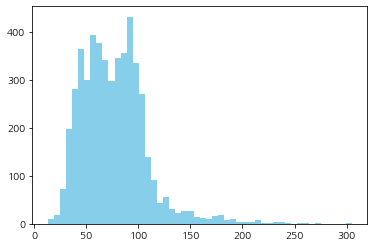

In [27]:
# 'encoded' 열의 각 리스트의 길이 계산
lengths = train_data['encoded'].apply(len)

print(f"최대 길이: {lengths.max()}")
print(f"최소 길이: {lengths.min()}")
print(f"평균 길이: {lengths.mean()}")
print(f"표준편차: {lengths.std()}")

# 길이 분포 시각화
plt.hist(lengths, bins=50, color='skyblue')
plt.show()

#### 패딩 적용

In [28]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [29]:
X = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [30]:
y = train_data['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3960
훈련 레이블의 개수 : 3960
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 495
테스트 레이블의 개수 : 495


# 모델링

In [31]:
!pip install wandb==0.16.0

  Using cached wandb-0.16.0-py3-none-any.whl (2.1 MB)


In [32]:
import wandb

wandb.login(key = '809618c39f10bc0019fd6fd710cb28c698c30197')

wandb: Currently logged in as: 4rldur0 (4-rldur0). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [33]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            },
        "batch_size": {
            "values": [16, 32, 64]
            },
        "optimizer": {
            "values": ["adam", "sgd", "rmsprop"]
            }           
        }
    }

default_config = {
        "vocab" : VOCAB_SIZE,
        "embeddings" : 128,
        "units_128" : 128,
        "units_256" : 256,
        "units_512" : 512,
        "units_1024" : 1024,
        "units_2048" : 2048,
        "kernel_3" : 3,
        "kernel_5" : 5,
        "dropout_rate": 0.2,
        "class_num" : 5,
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
    }

In [34]:
def build_model_baseline(config):
    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_256, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_512))
    model.add(keras.layers.Dense(config.units_1024, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))  
    return model

In [35]:
def build_model_1DCNN(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(config.units_128, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax')) 
    return model

In [36]:
def build_model_1DCNN_GRU(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.SpatialDropout1D(config.dropout_rate))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GRU(config.units_128, dropout=config.dropout_rate, recurrent_dropout=config.dropout_rate))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))
    return model

In [41]:
# heatmap으로 비교 결과를 그려주는 함수
def plot_table(cm):
    title = "Overall Prediction Result"
    # 실제 클래스명으로 변환
    classes = [
        '협박 대화',
        '갈취 대화',
        '직장 내 괴롭힘 대화',
        '기타 괴롭힘 대화',
        '일반 대화']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={'size': 30})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    return plt

# epoch이 모두 끝나면 각 클래스별 GT와 예측값을 비교한 표 시각화
# confusion matrix 활용하여 표 채움
class CompareResultsCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, class_num):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.class_num = class_num
        # 전체 표 초기화
        self.table = np.zeros((self.class_num, self.class_num), dtype=np.int32)

    def on_epoch_end(self, epoch, logs=None):
        # 마지막 epoch에서만 계산
        if epoch == self.params['epochs'] - 1:  
            pred_test = self.model.predict(self.X_test).argmax(axis=1)
            self.y_test = np.array(self.y_test)
            pred_test = np.array(pred_test)
            
            # 5개의 클래스에서 두 개씩 뽑아내어 총 10개의 쌍 만들기
            for class_a, class_b in combinations(range(self.class_num), 2):
                indices = np.where((self.y_test == class_a) | (self.y_test == class_b))[0]
                y_test_subset = self.y_test[indices]
                pred_test_subset = pred_test[indices]

                y_test_subset = np.where(y_test_subset == class_a, 0, 1)
                pred_test_subset = np.where(pred_test_subset == class_a, 0, 1)
                
                # 현재 쌍에 대해 confusion matrix 계산
                cm_pair = confusion_matrix(y_test_subset, pred_test_subset)
                
                # 전체 표에 각 클래스 쌍에 대한 예측 결과 개수 나타내기
                # 세로 축은 실제 클래스, 가로축은 예측된 클래스
                # 대각 요소는 정확하게 예측된 경우를 나타냄
                self.table[class_a, class_a] += cm_pair[0, 0]    # TP
                self.table[class_a, class_b] += cm_pair[0, 1]    # FN
                self.table[class_b, class_a] += cm_pair[1, 0]    # FP
                self.table[class_b, class_b] += cm_pair[1, 1]    # TN

            # 표 그리기
            cm_plot = plot_table(self.table)
            
            # wandb에 로그로 저장
            cm_image = wandb.Image(cm_plot)
            wandb.log({"Overall Prediction Result": cm_image})


In [42]:
# 학습 함수 정의
# CompareResultsCallback 테스트 데이터셋을 활용하므로 인자로 넣어줌
def train(default_config, X_test, y_test):

    wandb.init(config = default_config)
    config = wandb.config
    
    keras.backend.clear_session()

    # Model
    model = build_model_baseline(config)

    # Compile
    model.compile(optimizer = config.optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # confunsion matrix 그리는 콜백
    cm_callback = CompareResultsCallback(X_test, y_test, config.class_num)
    
    # 학습
    history = model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks=[wandb.keras.WandbCallback(), cm_callback])
    
    # test dataset으로 f1 score 계산
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    pred_test = model.predict(X_test).argmax(axis=1)
    f1_score_res = f1_score(y_test, pred_test, average='micro')

    # wandb에 log 추가
    wandb.log({
        "Test Accuracy Rate": test_accuracy,
        "Test F1 Score": f1_score_res,
        "Test Error Rate": 1 - test_accuracy
    })
    
    return history

In [ ]:
# train()에 인자가 있으므로 wrapper function 정의
def sweep_train():
    train(default_config=default_config, X_test=X_test, y_test=y_test)

# 팀프로젝트 내에서 sweep 실행
sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_minions',
                       project = 'DLthon_baseline')


wandb.agent(sweep_id,
            function=sweep_train,
            count=10)

Create sweep with ID: 2vzg3c6t
Sweep URL: https://wandb.ai/aiffel_minions/DLthon_baseline/sweeps/2vzg3c6t


wandb: Agent Starting Run: znuujv5h with config:
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.085703658164981
wandb: 	optimizer: sgd


Epoch 1/10
62/62 [==============================] - 7s 53ms/step - loss: 1.6090 - accuracy: 0.2109 - val_loss: 1.6076 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 2/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6085 - accuracy: 0.2139 - val_loss: 1.6067 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 3/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6083 - accuracy: 0.2139 - val_loss: 1.6060 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 4/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6081 - accuracy: 0.2139 - val_loss: 1.6057 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 5/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6080 - accuracy: 0.2139 - val_loss: 1.6055 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 6/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6079 - accuracy: 0.2139 - val_loss: 1.6052 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 7/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6079 - accuracy: 0.2139 - val_loss: 1.6049 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 8/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6079 - accuracy: 0.2139 - val_loss: 1.6049 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 9/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6078 - accuracy: 0.2139 - val_loss: 1.6048 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


Epoch 10/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6078 - accuracy: 0.2139 - val_loss: 1.6046 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102540-znuujv5h/files/model-best)... Done. 0.1s


16/16 - 0s - loss: 1.6094 - accuracy: 0.2323


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▂▂▂▁▁
Test Accuracy Rate,0.23232
Test Error Rate,0.76768
Test F1 Score,0.23232


wandb: Agent Starting Run: hodfnkbr with config:
wandb: 	batch_size: 32
wandb: 	epoch: 9
wandb: 	learning_rate: 0.05532562234904584
wandb: 	optimizer: rmsprop


Epoch 1/9
124/124 [==============================] - 7s 33ms/step - loss: 1.6141 - accuracy: 0.2071 - val_loss: 1.6027 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best)... Done. 0.1s


Epoch 2/9
124/124 [==============================] - 4s 29ms/step - loss: 1.6158 - accuracy: 0.2083 - val_loss: 1.6013 - val_accuracy: 0.1697


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best)... Done. 0.1s


Epoch 3/9
124/124 [==============================] - 4s 29ms/step - loss: 1.6064 - accuracy: 0.2083 - val_loss: 1.5993 - val_accuracy: 0.2646


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best)... Done. 0.1s


Epoch 4/9
124/124 [==============================] - 4s 29ms/step - loss: 1.5963 - accuracy: 0.2232 - val_loss: 1.5916 - val_accuracy: 0.2727


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102738-hodfnkbr/files/model-best)... Done. 0.1s


Epoch 5/9
124/124 [==============================] - 4s 29ms/step - loss: 1.5819 - accuracy: 0.2260 - val_loss: 1.6152 - val_accuracy: 0.2667
Epoch 6/9
124/124 [==============================] - 4s 28ms/step - loss: 1.5699 - accuracy: 0.2379 - val_loss: 1.6637 - val_accuracy: 0.1657
Epoch 7/9
124/124 [==============================] - 4s 29ms/step - loss: 1.5803 - accuracy: 0.2361 - val_loss: 1.6372 - val_accuracy: 0.2626
Epoch 8/9
124/124 [==============================] - 4s 29ms/step - loss: 1.5651 - accuracy: 0.2343 - val_loss: 1.6398 - val_accuracy: 0.1798
Epoch 9/9
124/124 [==============================] - 4s 29ms/step - loss: 1.5574 - accuracy: 0.2376 - val_loss: 1.6924 - val_accuracy: 0.1677
16/16 - 0s - loss: 1.6786 - accuracy: 0.1737


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▁▁▅▅██▇█
epoch,▁▂▃▄▅▅▆▇█
loss,██▇▆▄▂▄▂▁
val_accuracy,█▁▇██▁▇▂▁
val_loss,▂▂▂▁▃▆▄▄█
Test Accuracy Rate,0.17374
Test Error Rate,0.82626
Test F1 Score,0.17374


wandb: Agent Starting Run: tn532gu0 with config:
wandb: 	batch_size: 16
wandb: 	epoch: 8
wandb: 	learning_rate: 0.013890367809551971
wandb: 	optimizer: sgd


Epoch 1/8
248/248 [==============================] - 9s 27ms/step - loss: 1.6090 - accuracy: 0.2101 - val_loss: 1.6057 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best)... Done. 0.1s


Epoch 2/8
248/248 [==============================] - 5s 22ms/step - loss: 1.6083 - accuracy: 0.2114 - val_loss: 1.6051 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best)... Done. 0.1s


Epoch 3/8
248/248 [==============================] - 5s 22ms/step - loss: 1.6082 - accuracy: 0.2083 - val_loss: 1.6043 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best)... Done. 0.1s


Epoch 4/8
248/248 [==============================] - 5s 22ms/step - loss: 1.6079 - accuracy: 0.2129 - val_loss: 1.6070 - val_accuracy: 0.2667
Epoch 5/8
248/248 [==============================] - 5s 21ms/step - loss: 1.6080 - accuracy: 0.2109 - val_loss: 1.6056 - val_accuracy: 0.2667
Epoch 6/8
248/248 [==============================] - 5s 21ms/step - loss: 1.6080 - accuracy: 0.2139 - val_loss: 1.6051 - val_accuracy: 0.2667
Epoch 7/8
248/248 [==============================] - 5s 21ms/step - loss: 1.6078 - accuracy: 0.2129 - val_loss: 1.6057 - val_accuracy: 0.2667
Epoch 8/8
248/248 [==============================] - 5s 21ms/step - loss: 1.6080 - accuracy: 0.2078 - val_loss: 1.6043 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_102914-tn532gu0/files/model-best)... Done. 0.1s


16/16 - 0s - loss: 1.6097 - accuracy: 0.2323


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▄▅▂▇▅█▇▁
epoch,▁▂▃▄▅▆▇█
loss,█▄▃▁▂▂▁▂
val_accuracy,▁▁▁▁▁▁▁▁
val_loss,▅▃▁█▄▃▅▁
Test Accuracy Rate,0.23232
Test Error Rate,0.76768
Test F1 Score,0.23232


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ci6aujvh with config:
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.07100356995005078
wandb: 	optimizer: adam


Epoch 1/10
124/124 [==============================] - 8s 34ms/step - loss: 1.6109 - accuracy: 0.2066 - val_loss: 1.6113 - val_accuracy: 0.1636


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best)... Done. 0.2s


Epoch 2/10
124/124 [==============================] - 4s 30ms/step - loss: 1.6088 - accuracy: 0.2053 - val_loss: 1.6028 - val_accuracy: 0.1859


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best)... Done. 0.2s


Epoch 3/10
124/124 [==============================] - 4s 29ms/step - loss: 1.6007 - accuracy: 0.2051 - val_loss: 1.6179 - val_accuracy: 0.1697
Epoch 4/10
124/124 [==============================] - 4s 29ms/step - loss: 1.5912 - accuracy: 0.2157 - val_loss: 1.6102 - val_accuracy: 0.1657
Epoch 5/10
124/124 [==============================] - 4s 29ms/step - loss: 1.5819 - accuracy: 0.2235 - val_loss: 1.6022 - val_accuracy: 0.2687


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best)... Done. 0.2s


Epoch 6/10
124/124 [==============================] - 4s 30ms/step - loss: 1.5802 - accuracy: 0.2412 - val_loss: 1.5962 - val_accuracy: 0.2646


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103051-ci6aujvh/files/model-best)... Done. 0.2s


Epoch 7/10
124/124 [==============================] - 4s 30ms/step - loss: 1.5688 - accuracy: 0.2341 - val_loss: 1.6057 - val_accuracy: 0.2687
Epoch 8/10
124/124 [==============================] - 4s 29ms/step - loss: 1.5670 - accuracy: 0.2265 - val_loss: 1.6029 - val_accuracy: 0.2707
Epoch 9/10
124/124 [==============================] - 4s 30ms/step - loss: 1.5592 - accuracy: 0.2351 - val_loss: 1.6111 - val_accuracy: 0.2707
Epoch 10/10
124/124 [==============================] - 4s 29ms/step - loss: 1.5569 - accuracy: 0.2381 - val_loss: 1.6298 - val_accuracy: 0.2727
16/16 - 0s - loss: 1.6787 - accuracy: 0.2323


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▁▁▃▅█▇▅▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,██▇▅▄▄▃▂▁▁
val_accuracy,▁▂▁▁█▇████
val_loss,▄▂▆▄▂▁▃▂▄█
Test Accuracy Rate,0.23232
Test Error Rate,0.76768
Test F1 Score,0.23232


wandb: Agent Starting Run: auqtn9e6 with config:
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.053000361735418215
wandb: 	optimizer: adam


Epoch 1/10
62/62 [==============================] - 7s 57ms/step - loss: 1.6101 - accuracy: 0.2101 - val_loss: 1.6111 - val_accuracy: 0.1677


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best)... Done. 0.2s


Epoch 2/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6071 - accuracy: 0.2045 - val_loss: 1.5993 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best)... Done. 0.2s


Epoch 3/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6039 - accuracy: 0.2098 - val_loss: 1.5980 - val_accuracy: 0.2687


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103217-auqtn9e6/files/model-best)... Done. 0.2s


Epoch 4/10
62/62 [==============================] - 3s 44ms/step - loss: 1.5837 - accuracy: 0.2389 - val_loss: 1.6065 - val_accuracy: 0.2323
Epoch 5/10
62/62 [==============================] - 3s 44ms/step - loss: 1.6741 - accuracy: 0.2232 - val_loss: 1.6071 - val_accuracy: 0.1697
Epoch 6/10
62/62 [==============================] - 3s 43ms/step - loss: 1.5830 - accuracy: 0.2116 - val_loss: 1.6198 - val_accuracy: 0.2646
Epoch 7/10
62/62 [==============================] - 3s 43ms/step - loss: 1.5650 - accuracy: 0.2237 - val_loss: 1.6347 - val_accuracy: 0.2646
Epoch 8/10
62/62 [==============================] - 3s 44ms/step - loss: 1.5571 - accuracy: 0.2313 - val_loss: 1.6495 - val_accuracy: 0.1677
Epoch 9/10
62/62 [==============================] - 3s 44ms/step - loss: 1.5617 - accuracy: 0.2245 - val_loss: 1.6509 - val_accuracy: 0.2586
Epoch 10/10
62/62 [==============================] - 3s 44ms/step - loss: 1.5653 - accuracy: 0.2396 - val_loss: 1.6109 - val_accuracy: 0.2323
16/16 - 0s -

Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▂▁▂█▅▂▅▆▅█
epoch,▁▂▃▃▄▅▆▆▇█
loss,▄▄▄▃█▃▁▁▁▁
val_accuracy,▁██▅▁██▁▇▅
val_loss,▃▁▁▂▂▄▆██▃
Test Accuracy Rate,0.2404
Test Error Rate,0.7596
Test F1 Score,0.2404


wandb: Agent Starting Run: wmvjn2ve with config:
wandb: 	batch_size: 16
wandb: 	epoch: 8
wandb: 	learning_rate: 0.03280929485719605
wandb: 	optimizer: sgd


Epoch 1/8
248/248 [==============================] - 10s 25ms/step - loss: 1.6090 - accuracy: 0.2114 - val_loss: 1.6069 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best)... Done. 0.1s


Epoch 2/8
248/248 [==============================] - 5s 22ms/step - loss: 1.6084 - accuracy: 0.2116 - val_loss: 1.6061 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best)... Done. 0.1s


Epoch 3/8
248/248 [==============================] - 5s 22ms/step - loss: 1.6082 - accuracy: 0.2071 - val_loss: 1.6048 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best)... Done. 0.1s


Epoch 4/8
248/248 [==============================] - 5s 22ms/step - loss: 1.6080 - accuracy: 0.2129 - val_loss: 1.6042 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best)... Done. 0.1s


Epoch 5/8
248/248 [==============================] - 5s 22ms/step - loss: 1.6080 - accuracy: 0.2139 - val_loss: 1.6057 - val_accuracy: 0.2667
Epoch 6/8
248/248 [==============================] - 5s 22ms/step - loss: 1.6080 - accuracy: 0.2111 - val_loss: 1.6047 - val_accuracy: 0.2667
Epoch 7/8
248/248 [==============================] - 5s 21ms/step - loss: 1.6079 - accuracy: 0.2126 - val_loss: 1.6042 - val_accuracy: 0.2667
Epoch 8/8
248/248 [==============================] - 5s 21ms/step - loss: 1.6077 - accuracy: 0.2114 - val_loss: 1.6026 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103329-wmvjn2ve/files/model-best)... Done. 0.1s


16/16 - 0s - loss: 1.6079 - accuracy: 0.2323


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▅▆▁▇█▅▇▅
epoch,▁▂▃▄▅▆▇█
loss,█▅▄▃▃▃▂▁
val_accuracy,▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▆▄▄▁
Test Accuracy Rate,0.23232
Test Error Rate,0.76768
Test F1 Score,0.23232


wandb: Agent Starting Run: ippbrmbg with config:
wandb: 	batch_size: 32
wandb: 	epoch: 9
wandb: 	learning_rate: 0.028638907574263073
wandb: 	optimizer: adam


Epoch 1/9
124/124 [==============================] - 7s 34ms/step - loss: 1.6118 - accuracy: 0.1924 - val_loss: 1.6044 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best)... Done. 0.2s


Epoch 2/9
124/124 [==============================] - 4s 30ms/step - loss: 1.6082 - accuracy: 0.2058 - val_loss: 1.6006 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best)... Done. 0.2s


Epoch 3/9
124/124 [==============================] - 4s 30ms/step - loss: 1.6022 - accuracy: 0.2154 - val_loss: 1.6025 - val_accuracy: 0.1677
Epoch 4/9
124/124 [==============================] - 4s 29ms/step - loss: 1.5934 - accuracy: 0.2255 - val_loss: 1.6001 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103511-ippbrmbg/files/model-best)... Done. 0.2s


Epoch 5/9
124/124 [==============================] - 4s 30ms/step - loss: 1.5753 - accuracy: 0.2177 - val_loss: 1.6058 - val_accuracy: 0.2687
Epoch 6/9
124/124 [==============================] - 4s 29ms/step - loss: 1.5700 - accuracy: 0.2225 - val_loss: 1.6359 - val_accuracy: 0.2707
Epoch 7/9
124/124 [==============================] - 4s 29ms/step - loss: 1.5703 - accuracy: 0.2331 - val_loss: 1.6069 - val_accuracy: 0.2646
Epoch 8/9
124/124 [==============================] - 4s 30ms/step - loss: 1.5652 - accuracy: 0.2306 - val_loss: 1.6162 - val_accuracy: 0.2626
Epoch 9/9
124/124 [==============================] - 4s 30ms/step - loss: 1.5699 - accuracy: 0.2290 - val_loss: 1.6381 - val_accuracy: 0.2667
16/16 - 0s - loss: 1.6203 - accuracy: 0.2343


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▇▅▆██▇
epoch,▁▂▃▄▅▅▆▇█
loss,█▇▇▅▃▂▂▁▂
val_accuracy,██▁████▇█
val_loss,▂▁▁▁▂█▂▄█
Test Accuracy Rate,0.23434
Test Error Rate,0.76566
Test F1 Score,0.23434


wandb: Agent Starting Run: 6rj7mw3i with config:
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0386736507660572
wandb: 	optimizer: rmsprop


Epoch 1/5
124/124 [==============================] - 7s 34ms/step - loss: 1.6145 - accuracy: 0.2040 - val_loss: 1.6069 - val_accuracy: 0.2646


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103648-6rj7mw3i/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103648-6rj7mw3i/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103648-6rj7mw3i/files/model-best)... Done. 0.1s


Epoch 2/5
124/124 [==============================] - 4s 29ms/step - loss: 1.6143 - accuracy: 0.2081 - val_loss: 1.5985 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103648-6rj7mw3i/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103648-6rj7mw3i/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103648-6rj7mw3i/files/model-best)... Done. 0.1s


Epoch 3/5
124/124 [==============================] - 4s 29ms/step - loss: 1.6074 - accuracy: 0.1995 - val_loss: 1.6017 - val_accuracy: 0.1697
Epoch 4/5
124/124 [==============================] - 4s 29ms/step - loss: 1.5954 - accuracy: 0.2215 - val_loss: 1.6067 - val_accuracy: 0.2646
Epoch 5/5
124/124 [==============================] - 4s 29ms/step - loss: 1.6003 - accuracy: 0.2278 - val_loss: 1.6106 - val_accuracy: 0.2626
16/16 - 0s - loss: 1.6332 - accuracy: 0.2343


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▂▃▁▆█
epoch,▁▃▅▆█
loss,██▅▁▃
val_accuracy,██▁██
val_loss,▆▁▃▆█
Test Accuracy Rate,0.23434
Test Error Rate,0.76566
Test F1 Score,0.23434


wandb: Agent Starting Run: k175i1um with config:
wandb: 	batch_size: 16
wandb: 	epoch: 9
wandb: 	learning_rate: 0.02279383787188996
wandb: 	optimizer: adam


Epoch 1/9
248/248 [==============================] - 10s 29ms/step - loss: 1.6112 - accuracy: 0.2035 - val_loss: 1.6054 - val_accuracy: 0.2646


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best)... Done. 0.2s


Epoch 2/9
248/248 [==============================] - 6s 23ms/step - loss: 1.6103 - accuracy: 0.2146 - val_loss: 1.5990 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best)... Done. 0.2s


Epoch 3/9
248/248 [==============================] - 6s 23ms/step - loss: 1.6045 - accuracy: 0.2157 - val_loss: 1.5960 - val_accuracy: 0.2707


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240625_103739-k175i1um/files/model-best)... Done. 0.2s


Epoch 4/9
248/248 [==============================] - 6s 23ms/step - loss: 1.5980 - accuracy: 0.2220 - val_loss: 1.6014 - val_accuracy: 0.2646
Epoch 5/9
248/248 [==============================] - 6s 23ms/step - loss: 1.5947 - accuracy: 0.2098 - val_loss: 1.6038 - val_accuracy: 0.2626
Epoch 6/9
127/248 [==============>...............] - ETA: 2s - loss: 1.5910 - accuracy: 0.2116